In [ ]:
%%capture
!pip install fastai --upgrade
!pip install -U albumentations[imgaug]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as albu

from fastai.vision.all import *
from fastai.metrics import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error

from time import time

from torch.nn.functional import interpolate

import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
pathlib.WindowsPath = pathlib.PosixPath

## Data Loading

In [ ]:
bs = 128

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/Data/LaneImgs/train'
TEST_DIR = '/content/drive/MyDrive/Data/LaneImgs/test'

In [ ]:
train_data = []
for path in os.scandir(TRAIN_DIR):
    image = cv2.imread(path.path, cv2.IMREAD_GRAYSCALE)
    throttle = float(path.name.split('_')[3])
    steer = float(path.name.split('_')[5][:-4])
    train_data.append([steer, throttle, image])

train_df = pd.DataFrame(train_data, columns=['steer', 'throttle', 'image'])

In [ ]:
test_data = []
for path in os.scandir(TEST_DIR):
    image = cv2.imread(path.path, cv2.IMREAD_GRAYSCALE)
    throttle = float(path.name.split('_')[3])
    steer = float(path.name.split('_')[5][:-4])
    test_data.append([steer, throttle, image])

test_df = pd.DataFrame(test_data, columns=['steer', 'throttle', 'image'])

### Model Training

In [ ]:
imgs = test_df['image'].tolist()

In [ ]:
cbs = [
    ReduceLROnPlateau(monitor='valid_loss', min_delta=0.0005, patience=7),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=12),
    ShowGraphCallback()
    ]

In [ ]:
class AlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
      x0 = x[0]

      imgs = []
      for i in range(len(x0)):
        img = np.array(x0[i].cpu())[0]
        aug = self.aug(image=img)
        img = PILImageBW.create(aug["image"])
        img = TensorImageBW(img).cuda().unsqueeze(0)
        imgs.append(img)

      if len(x) == 2:
        return [torch.stack(imgs), x[1]]
      else:
        return [torch.stack(imgs)]


albu_transform_list = [
    albu.Resize(224, 244, always_apply=True),
    albu.GaussNoise(p=0.2),
    albu.OneOf(
        [
            albu.CLAHE(p=1),
            albu.RandomBrightnessContrast(p=1),
            albu.RandomGamma(p=1),
        ],
        p=0.5,
    ),
    albu.OneOf(
        [
            albu.Sharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.5,
    ),
    albu.OneOf(
        [
            albu.RandomBrightnessContrast(p=1),
        ],
        p=0.5,
    ),
]
albu_transform = albu.Compose(albu_transform_list)

#### Model

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), RegressionBlock(n_out=2)),
    get_x=ColReader('image'),
    get_y=ColReader(['steer', 'throttle']),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(
        224
    ),
    batch_tfms=[
        # AlbumentationsTransform(albu_transform),
        # *aug_transforms(
        #     do_flip=False,
        #     max_rotate=0,
        #     max_zoom=1.25,
        #     max_lighting=0.25,
        #     max_warp=0.2
        #     ),
        Normalize.from_stats(*imagenet_stats),
        ]
)

dls = dblock.dataloaders(train_df, bs=128)

In [ ]:
from fastai.vision.models import mobilenet_v3_small, resnet18

# learn = load_learner("/content/drive/MyDrive/gp_models/regression_raw_albu_bs128_1703614816.0306551.pkl")

arch = mobilenet_v3_small
learn = Learner(
                dls,
                create_vision_model(arch, 2),
                MSELossFlat(),
                cbs = cbs,
                metrics=rmse,
                )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning Rate: 0.0014454397605732083


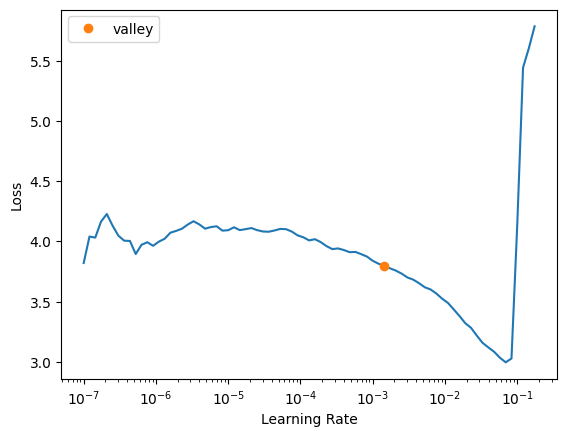

In [ ]:
lr = learn.lr_find()
print(f"Learning Rate: {lr[0]}")

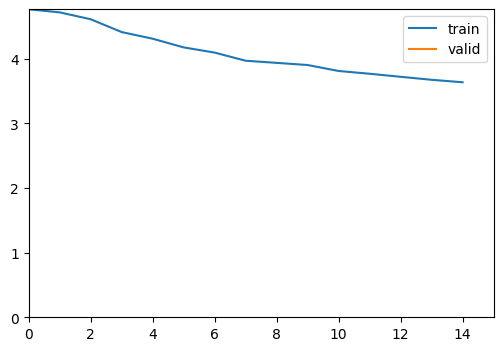

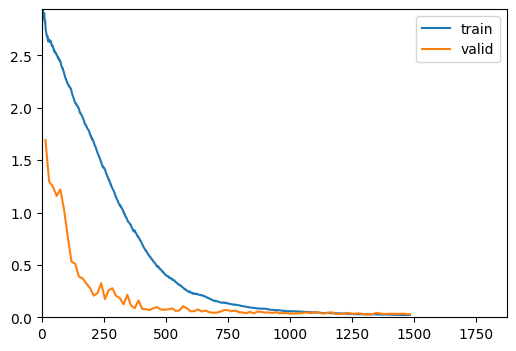

Epoch 53: reducing lr to 6.616250064868251e-05
Epoch 63: reducing lr to 5.718345724697896e-05
Epoch 74: reducing lr to 4.42615910493446e-05
Epoch 94: reducing lr to 1.908903277709202e-05
No improvement since epoch 87: early stopping


In [ ]:
start = time()
learn.fine_tune(
    125,
    base_lr=lr[0]
    )

Model Testing

In [ ]:
test_dl = dls.test_dl(test_df, with_labels=True)
test_results = learn.get_preds(dl=test_dl)

In [ ]:
print(f"Test Loss:\t{learn.loss_func(*test_results).item():.4f}\nTest RMSE:\t{rmse(*test_results).item():.4f}")

Test Loss:	0.0383
Test RMSE:	0.1956


In [ ]:
throttle_preds = [preds[1].item() for preds in test_results[0]]
throttle_true = [preds[1].item() for preds in test_results[1]]
steer_preds = [preds[0].item() for preds in test_results[0]]
steer_true = [preds[0].item() for preds in test_results[1]]

In [ ]:
steer_mae = mean_absolute_error(steer_true, steer_preds)
throttle_mae = mean_absolute_error(throttle_true, throttle_preds)

In [ ]:
print(f"Steer MAE:\t{steer_mae:.4f}\nThrottle MAE:\t{throttle_mae:.4f}")

Tensor transformation to speed up prediction

In [ ]:
def quick_predict(model, img):
    with torch.no_grad():
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).transpose(2,0,1).astype('float32')/255
        image_tensor = TensorImageBW(img).cuda().unsqueeze(0)
        model_output = model.forward(image_tensor).cpu().numpy()
    return model_output

In [ ]:
times = []
for img in imgs:
    start = time()
    y_pred = learn.predict(PILImage.create(img))
    times.append(time() - start)
average_time = sum(times) / len(times)

In [ ]:
print(f"Avg Prediction Time:\t{(average_time*1000):.4f}ms")

In [ ]:
times = []
for img in imgs:
    start = time()
    y_pred = quick_predict(learn, img)
    times.append(time() - start)
average_time = sum(times) / len(times)

In [ ]:
print(f"Avg Time w/ Tensor Transformation:\t{(average_time*1000):.4f}ms")

In [ ]:
plt.scatter(steer_preds, throttle_preds, label='Predictions')
plt.scatter(steer_true, throttle_true, label='Ground Truth')
plt.title(f'mobilenetv3 w/ Albumination\nsteer MAE: {steer_mae:.3f}, throttle MAE: {throttle_mae:.3f}')
plt.xlabel('steer')
plt.ylabel('throttle')
plt.legend()
plt.show()

checking if rounding the will improve results

In [ ]:
def round_pred(pred, threshold = 0):
  if pred < 0.4 and pred > threshold:
    return 0.4
  elif pred < threshold:
    return -1
  else:
    return pred

In [ ]:
tmp = {
    "Orig": throttle_preds,
    "0": [round_pred(pred, 0) for pred in throttle_preds],
    "-.2": [round_pred(pred, -.2) for pred in throttle_preds],
    "-.4": [round_pred(pred, -.4) for pred in throttle_preds],
    "-.6": [round_pred(pred, -.6) for pred in throttle_preds],
}

In [ ]:
for name, preds in tmp.items():
  mae = mean_absolute_error(throttle_true, preds)
  print(f"Throttle MAE for {name}:\t{mae:.4f}")

In [ ]:
learn.export(f"/content/drive/MyDrive/gp_models/regression_mobilenetv3_noaugmentation.pkl")

#### comparing pretrained models

In [ ]:
with_aug = False
batch_tfms=[Normalize.from_stats(*imagenet_stats)]
if with_aug:
    batch_tfms.append(
        *aug_transforms(
            do_flip=True,
            max_rotate=10,
            max_zoom=1.1,
            max_lighting=0.25,
            max_warp=0.1
            )
    )

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock(n_out=2)),
    get_x=ColReader('image'),
    get_y=ColReader(['steer', 'throttle']),
    splitter=RandomSplitter(valid_pct=0.15, seed=42),
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
)

dls = dblock.dataloaders(train_df, bs=bs)

In [ ]:
from fastai.vision.models import mobilenet_v3_small, alexnet, densenet121, vgg16_bn

models = {
    'alexnet': alexnet,
    'densenet121': densenet121,
    'vgg16_bn': vgg16_bn,
    'mobilenet_v3_small': mobilenet_v3_small,
}

# index 0: training_time, 1: (dl_loss, dl_rmse, dl_exp_rmse), 2: (dl_steer_mae, dl_throttle_mae), 3: avg_pred_time, (average_steer_mae, average_throttle_mae)
results = {
    'resnet34': [],
    'alexnet': [],
    'densenet121': [],
    'vgg16_bn': [],
    'mobilenet_v3_small': []
}

resnet34


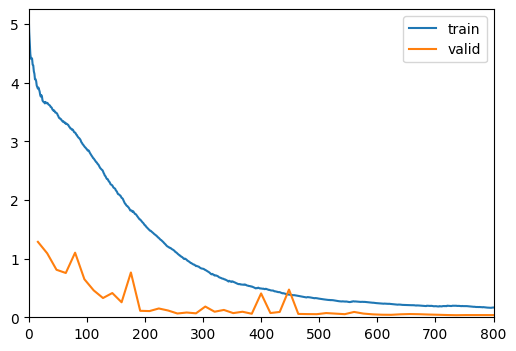

Epoch 20: reducing lr to 8.80204202051974e-05
Epoch 35: reducing lr to 3.086651972346168e-05
Epoch 43: reducing lr to 6.312323063036962e-06


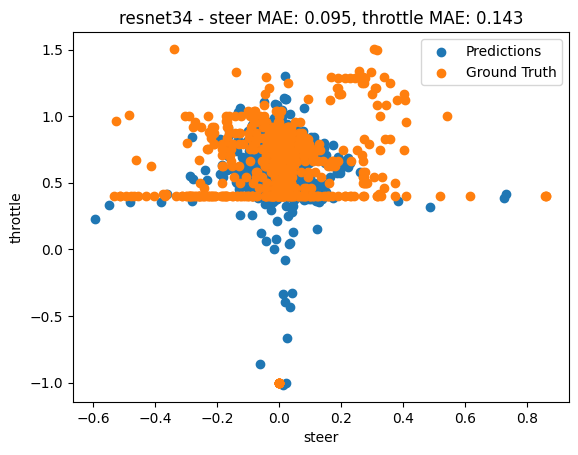

alexnet


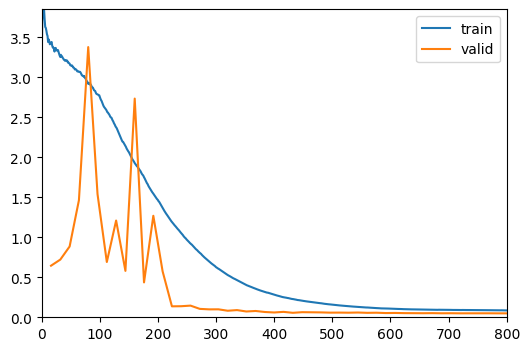

Epoch 5: reducing lr to 4.823396250901733e-05
Epoch 31: reducing lr to 4.7122320828781375e-05
Epoch 49: reducing lr to 1.6854284905004277e-09


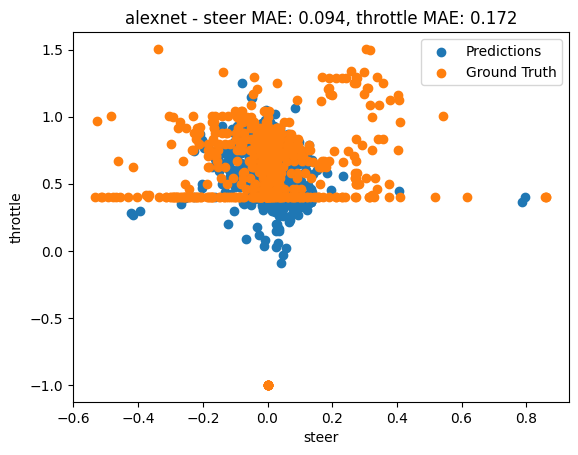

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


densenet121


100%|██████████| 30.8M/30.8M [00:00<00:00, 179MB/s]


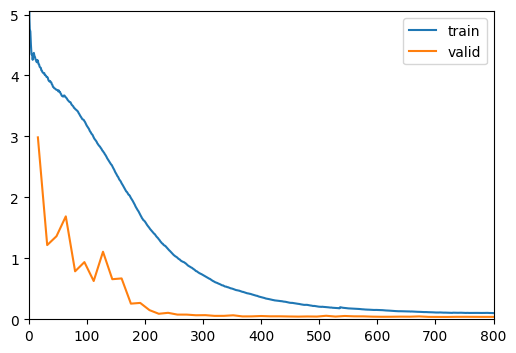

Epoch 33: reducing lr to 3.883810716303175e-05
Epoch 48: reducing lr to 1.9894520497428912e-07


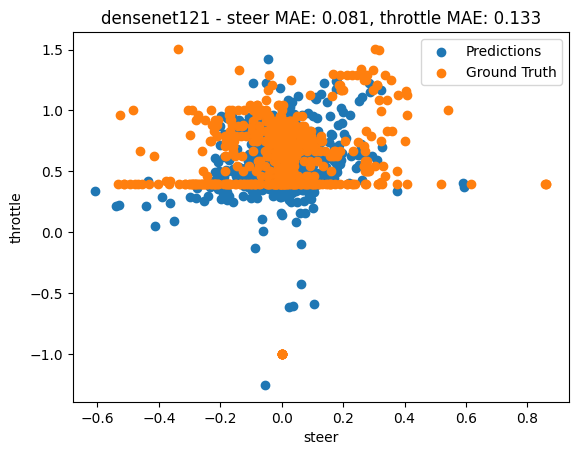

vgg16_bn


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 92.0MB/s]


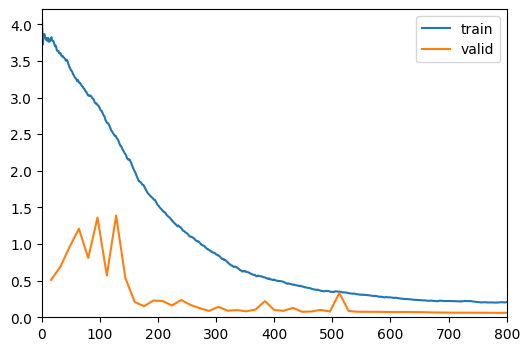

Epoch 5: reducing lr to 4.823396250901733e-05
Epoch 15: reducing lr to 9.79410075772946e-05
Epoch 26: reducing lr to 6.76740668528484e-05
Epoch 32: reducing lr to 4.2955506258367074e-05


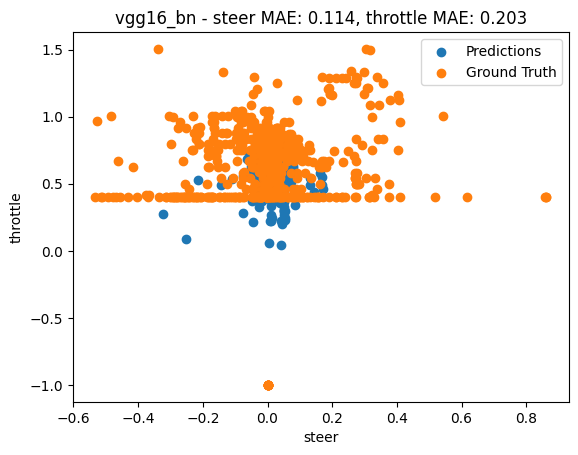

mobilenet_v3_small


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 89.3MB/s]


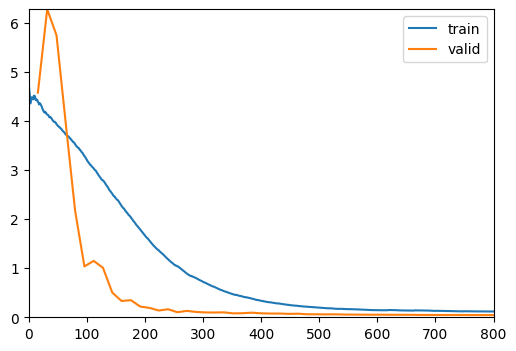

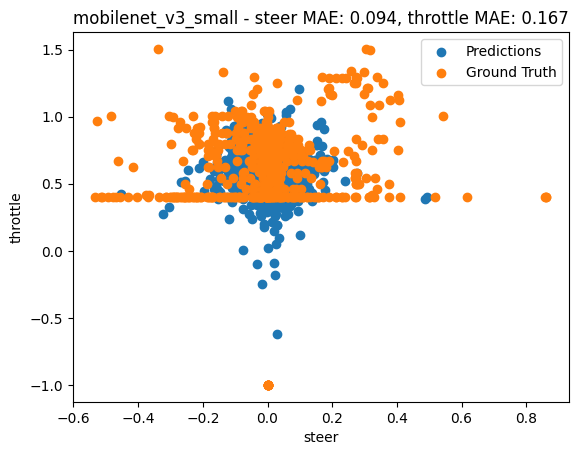

In [ ]:
for model_name, model in models.items():
    print(model_name)
    learn = Learner(
                    dls,
                    create_vision_model(model, 2),
                    MSELossFlat(),
                    cbs = cbs,
                    metrics=rmse,
                    )

    start = time()
    learn.fit_one_cycle(50)
    results[model_name].append(time() - start)

    test_dl = dls.test_dl(test_df, with_labels=True)
    test_results = learn.get_preds(dl=test_dl)
    test_loss = learn.loss_func(*test_results)
    test_rmse = rmse(*test_results)
    results[model_name].extend([test_loss.item(), test_rmse.item()])

    throttle_preds = [preds[1].item() for preds in test_results[0]]
    throttle_true = [preds[1].item() for preds in test_results[1]]
    steer_preds = [preds[0].item() for preds in test_results[0]]
    steer_true = [preds[0].item() for preds in test_results[1]]
    steer_mae = mean_absolute_error(steer_true, steer_preds)
    throttle_mae = mean_absolute_error(throttle_true, throttle_preds)

    results[model_name].extend([steer_mae, throttle_mae])

    times = []
    for idx, img in enumerate(imgs):
        start = time()
        learn.predict(img)
        times.append(time() - start)

    average_time = (sum(times) / len(times))*1000

    results[model_name].append(average_time)

    plt.scatter(steer_preds, throttle_preds, label='Predictions')
    plt.scatter(steer_true, throttle_true, label='Ground Truth')
    plt.title(f'{model_name} - steer MAE: {steer_mae:.3f}, throttle MAE: {throttle_mae:.3f}')
    plt.xlabel('steer')
    plt.ylabel('throttle')
    plt.legend()
    plt.show()

In [ ]:
print(results)

{'resnet34': [193.4748432636261, 0.03769874572753906, 0.19416165351867676, 0.0947402109342176, 0.1427788683477445, 28.902461888144817], 'alexnet': [144.00679111480713, 0.044606875628232956, 0.21120339632034302, 0.09419432208183519, 0.17177469649833643, 21.885014044021286], 'densenet121': [330.3838622570038, 0.031356144696474075, 0.17707666754722595, 0.08132928634829203, 0.13304367061324018, 53.0071532900175], 'vgg16_bn': [363.16070079803467, 0.0556056872010231, 0.2358085811138153, 0.11372006237635168, 0.20250322734952167, 24.464653222255613], 'mobilenet_v3_small': [180.2467439174652, 0.04202211648225784, 0.20499296486377716, 0.09433617128807949, 0.16732060287081346, 32.42475828050215]}


In [ ]:
rows = []
results_list = [[k] + v for k, v in results.items()]
headers = [
   "Training Time (s)",
   "MAE Loss",
   "RMSE Loss",
   "Steer MAE",
   "Throttle MAE",
   "Avg. Prediction Time (ms)",
]

In [ ]:
from tabulate import tabulate

print(tabulate(results_list, headers=headers, floatfmt=".3f"))

                      Training Time (s)    MAE Loss    RMSE Loss    Steer MAE    Throttle MAE    Avg. Prediction Time (ms)
------------------  -------------------  ----------  -----------  -----------  --------------  ---------------------------
resnet34                        193.475       0.038        0.194        0.095           0.143                       28.902
alexnet                         144.007       0.045        0.211        0.094           0.172                       21.885
densenet121                     330.384       0.031        0.177        0.081           0.133                       53.007
vgg16_bn                        363.161       0.056        0.236        0.114           0.203                       24.465
mobilenet_v3_small              180.247       0.042        0.205        0.094           0.167                       32.425
